In [154]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
from sqlalchemy import create_engine, MetaData, Table, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from flask import Flask
from flask_sqlalchemy import SQLAlchemy

In [7]:
# Use SQLAlchemy `create_engine` to connect to your sqlite database.
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# inspect tables and columns
inspector = inspect(engine)

inspector.get_table_names()

['Measurements', 'Stations']

In [9]:
# print the keys for the created classes
Base.classes.keys()

['Measurements', 'Stations']

In [24]:
# print list of column names for Measurements
columns_M = inspector.get_columns('Measurements')

for column in columns_M:
    print(column['name'], column['type'])

record_id INTEGER
station VARCHAR(255)
date DATE
precip FLOAT
temp FLOAT


In [26]:
# print list of column names for Stations
columns_S = inspector.get_columns('Stations')

for column in columns_S:
    print(column['name'], column['type'])

station_id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# save a reference to those classes called `Station` and `Measurement`.
Station = Base.classes.Stations
Measurement = Base.classes.Measurements

# Create session
session = Session(engine)

In [27]:
# Check the data
for instance in session.query(Measurement.temp).limit(10).all():
    print(instance)

(65.0,)
(63.0,)
(74.0,)
(76.0,)
(73.0,)
(70.0,)
(64.0,)
(68.0,)
(73.0,)
(64.0,)


### Precipitation Analysis


In [177]:
# Retrieve the last 12 months of precipitation data. Select only the `date` and `prcp` values.
    # first find latest date, which turns out to be '2017-08-23'
Latest_date = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).first()
Latest_date = pd.to_datetime(Latest_date)
    # Note: HAVE to convert to datetime object first. Apparently python can't subtract from date object.
    
    # subtract one year from it
year_date = Latest_date - timedelta(days=365)
year_date = pd.to_datetime(year_date[0])

year_date

Timestamp('2016-08-23 00:00:00')

In [167]:
# Query the last 12 months, averaging precip between the various weather stations
Last12Precip = session.query(Measurement.date, func.avg(Measurement.precip))\
                            .filter(Measurement.date >= year_date)\
                            .group_by(Measurement.date)\
                            .order_by(Measurement.date.desc())
    # note, specific datetime has to be this format 'yyyy-mm-dd' 
    
for instance in Last12Precip:
    print(instance)


(datetime.date(2017, 8, 23), 0.1325)
(datetime.date(2017, 8, 22), 0.16666666666666666)
(datetime.date(2017, 8, 21), 0.19333333333333336)
(datetime.date(2017, 8, 20), 0.005)
(datetime.date(2017, 8, 19), 0.03)
(datetime.date(2017, 8, 18), 0.02)
(datetime.date(2017, 8, 17), 0.0475)
(datetime.date(2017, 8, 16), 0.1525)
(datetime.date(2017, 8, 15), 0.164)
(datetime.date(2017, 8, 14), 0.062)
(datetime.date(2017, 8, 13), 0.0)
(datetime.date(2017, 8, 12), 0.04666666666666667)
(datetime.date(2017, 8, 11), 0.0)
(datetime.date(2017, 8, 10), 0.0175)
(datetime.date(2017, 8, 9), 0.049999999999999996)
(datetime.date(2017, 8, 8), 0.11000000000000001)
(datetime.date(2017, 8, 7), 0.0125)
(datetime.date(2017, 8, 6), 0.0)
(datetime.date(2017, 8, 5), 0.03)
(datetime.date(2017, 8, 4), 0.015)
(datetime.date(2017, 8, 3), 0.017499999999999998)
(datetime.date(2017, 8, 2), 0.075)
(datetime.date(2017, 8, 1), 0.04666666666666666)
(datetime.date(2017, 7, 31), 0.0)
(datetime.date(2017, 7, 30), 0.06)
(datetime.date(2

In [168]:
# saving dates and prcp values from the query
date = [row[0] for row in Last12Precip]
prcp = [row[1] for row in Last12Precip]

# checking if I only stored one value for each variable
print(date[0])

2017-08-23


In [169]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
Prcp_df = pd.DataFrame(list(zip(date, prcp)), columns=['date', 'prcp']) 
Prcp_df.set_index('date', inplace=True)
Prcp_df.tail()

,prcp
date,
2016-08-27,0.064000
2016-08-26,0.016667
2016-08-25,0.077143
2016-08-24,1.555000
2016-08-23,0.451667


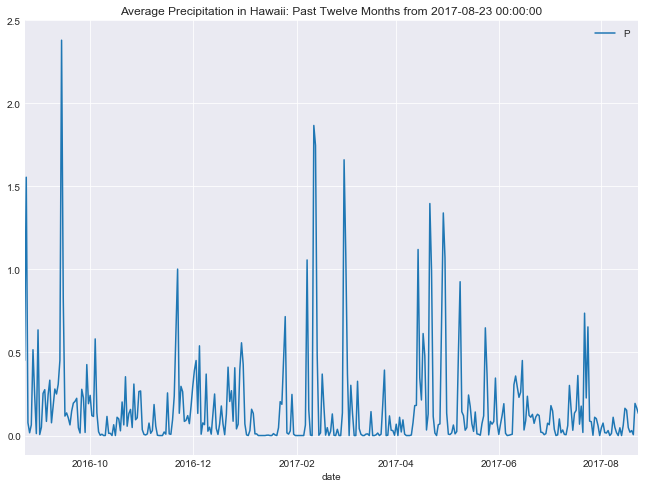

In [184]:
# Plot the results using the DataFrame `plot` method.
sns.set_style('darkgrid')
ax = Prcp_df.plot(figsize=(11, 8))
plt.title('Average Precipitation in Hawaii: Past Twelve Months from ' + str(Latest_date[0]))
ax.legend('Precipitation')
plt.show()